In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
from PIL import Image

In [3]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, file) for file in os.listdir(root)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = image

        return transformed_image

In [4]:

# Define data transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

batch_size = 128

train_dataset = MyDataset(root='/content/drive/your_location', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))

val_dataset = MyDataset(root='/content/drive/your_location', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MyDataset(root='/content/drive/your_location', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Define a custom VAE class
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(16),
        )
        self.encoder_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(filter_size[i-1], filter_size[i], kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.02),
                nn.BatchNorm2d(filter_size[i])
            )
            for i in range(1, len(filter_size))
        ])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2_mu = nn.Linear(512, latent_dim)
        self.fc2_log_var = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.decoder_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(d_filter_size[i-1], d_filter_size[i], kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(0.02),
                nn.BatchNorm2d(d_filter_size[i])
            )
            for i in range(1, len(d_filter_size))
        ])
        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1)
        )

    def encode(self, x):
        # print(x.shape)
        x = self.encoder(x)
        # print(x.shape)
        for conv_block in self.encoder_conv_blocks:
            x = conv_block(x)
            # print(x.shape)
        x = self.flatten(x)
        x = self.fc1(x)
        mu = self.fc2_mu(x)
        log_var = self.fc2_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        # print(z.shape)
        x = self.decoder(z)
        # print(x.shape)
        x = x.view(x.size(0), 256, 2, 2)
        # print(x.shape)
        for conv_block in self.decoder_conv_blocks:
            # print(conv_block)
            x = conv_block(x)
            # print(x.shape)
        # print(x.shape)
        x = self.final_conv(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        # print(z)
        return self.decode(z), mu, log_var

# Set model parameters
latent_dim = 64
filter_size = [16, 32, 64, 128, 256]
d_filter_size = [256, 128, 64, 32, 16]

In [6]:
# Create the VAE model
vae = VAE(latent_dim)

# Define the loss functions
loss_function = nn.MSELoss()
def kl_loss(mu, log_var):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.0001, weight_decay=1e-5)

In [7]:
path = "/content/drive/MyDrive/model/vae_checkpoint_200e.pth"
train_losses = []
val_losses = []

# Check if a checkpoint exists to resume training
if os.path.exists(path):
  checkpoint = torch.load(path)
  vae.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  train_losses = checkpoint["train_loss"]
  val_losses = checkpoint["valid_loss"]
  start_epoch = checkpoint["epoch"] + 1  # Start from the next epoch after the loaded checkpoint
  print("Resume training from epoch", start_epoch)
else:
  start_epoch = 1

Resume training from epoch 501


In [8]:
# Training parameters
epochs = 200

# Training loop
for epoch in range(start_epoch, epochs+1):
    vae.train()
    s_time = time.time()
    t_loss = 0.0
    for step, training_batch in enumerate(train_loader):
        optimizer.zero_grad()
        # print(training_batch.shape)
        reconstructed, mu, log_var = vae(training_batch)
        # print(reconstructed.shape)
        mse_loss = loss_function(reconstructed, training_batch)
        kl = kl_loss(mu, log_var)
        train_loss = 0.01 * kl + mse_loss
        t_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    t_loss /= len(train_loader)
    train_losses.append(t_loss)

    v_loss = 0.0
    for step, validation_batch in enumerate(val_loader):
        vae.eval()
        reconstructed, mu, log_var = vae(validation_batch)
        mse_loss = loss_function(reconstructed, validation_batch)
        kl = kl_loss(mu, log_var)
        validation_loss = 0.01 * kl + mse_loss
        v_loss += validation_loss.item()
    v_loss /= len(val_loader)
    val_losses.append(v_loss)
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {t_loss:.4f}, Val Loss: {v_loss:.4f}, Time: {(time.time()-s_time):.2f} sec")

    # Save model checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'valid_loss': val_losses,
    }
    torch.save(checkpoint, path)



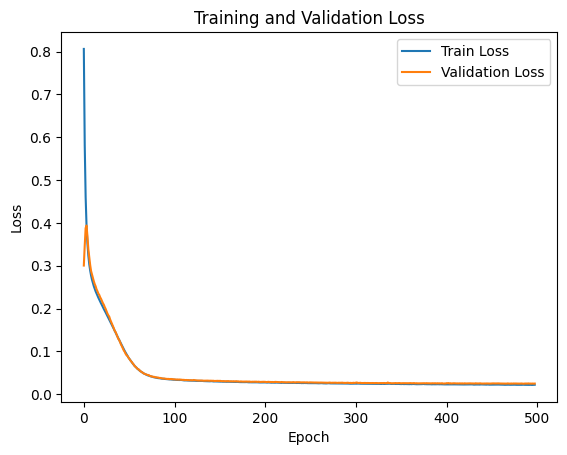

In [9]:
# Visualize the training and validation loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

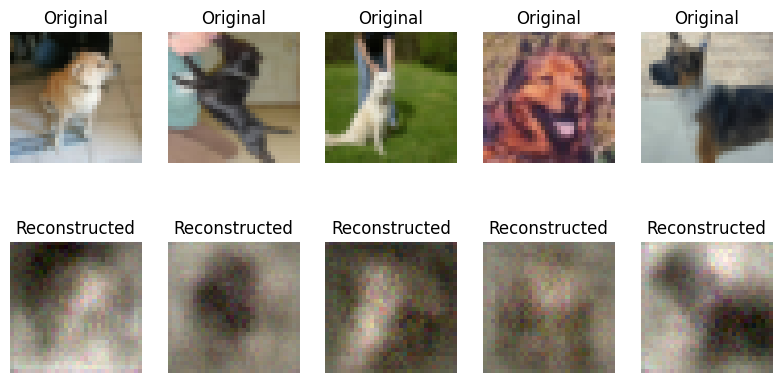

In [10]:
vae.eval()

# Initialize lists to store original and reconstructed images
original_images = []
reconstructed_images = []

# Run inference on the test dataset
with torch.no_grad():
    for test_batch in val_loader:
        # Get the reconstructed images from the VAE
        reconstructed_batch, _, _ = vae(test_batch)

        # Append the original and reconstructed images to their respective lists
        original_images.append(test_batch)
        reconstructed_images.append(reconstructed_batch)

# Combine the original and reconstructed images
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Function to display original and reconstructed images
def display_images(original, reconstructed):
    plt.figure(figsize=(20, 5))
    for i in range(5):  # Display the first 10 images
        plt.subplot(2, 10, i + 1)
        plt.imshow(original[i].permute(1, 2, 0).numpy())
        plt.title('Original')
        plt.axis('off')
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].permute(1, 2, 0).numpy())
        plt.title('Reconstructed')
        plt.axis('off')
        plt.show()

# Display original and reconstructed images
display_images(original_images, reconstructed_images)